In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import math
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn

Suggestion: try PLA on this dataset before using the bank dataset

In [2]:
X, y = make_blobs(n_samples=1000, centers=2, n_features=2)
y = [yy if yy == 1 else -1 for yy in y] 

In [3]:
def h(x,w):
    #Perceptron model: the sign of the dot product of weights and input vector determines the class allocation
    bias = np.array([1])
    return np.sign(w.T.dot(np.concatenate((bias,x))))

In [4]:
def point_on_boundary(weights, x):
    # Return the y-position on the boundary based on given x-position
    return -(weights[0]+weights[1]*x)/weights[2]

In [5]:
def decision_boundary(weights, x_min, x_max):
    # Return two points on the decision boundary
    return [pointOnBoundary(weights,x_min), pointOnBoundary(weights, x_max)]

In [6]:
def pla(training_in, training_out, weights):
    bias = np.array([1])
    iterations=0
    while True:
        errors = 0;
        for x,y in zip(training_in, training_out):
            if (h(x,weights)!=y):
                iterations+=1;
                weights = weights + y*(np.concatenate((bias,x)))
                errors+=1;
        if (errors == 0):
            break
    return weights, iterations

In [7]:
def calc_error(training_in, training_out, weights):
    # Calculate the classification error as the fraction of training samples that are misclassified
    errors=0
    for x,y in zip(training_in, training_out):
        if (h(x,weights)!=y):
            errors+=1;
    return errors/len(training_in)

### Task 1

In [8]:
# Load dataset into pandas frame
df = pd.read_csv('./bank_et1.csv')

In [9]:
# Print first 5 rows of the dataframe
df.head(5)

,Unnamed: 0,age,job,marital,education,default,balance,ratio_bal_ln,ratio_ln_inc,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,0,32,technician,single,tertiary,no,392,1.300134,0.473895,yes,no,cellular,1,apr,957,2,131,2,failure,no
1,1,39,technician,divorced,secondary,no,688,-0.193701,0.237021,yes,yes,cellular,1,apr,233,2,133,1,failure,no
2,2,59,retired,married,secondary,no,1035,1.334266,0.121981,yes,yes,cellular,1,apr,126,2,239,1,failure,no
3,3,47,blue-collar,married,secondary,no,398,0.362286,1.251328,yes,yes,cellular,1,apr,274,1,238,2,failure,no
4,4,54,retired,married,secondary,no,1004,0.072075,-0.533738,yes,no,cellular,1,apr,479,1,307,1,failure,no


In [10]:
# Print last 5 rows of the dataframe
df.tail(5)

,Unnamed: 0,age,job,marital,education,default,balance,ratio_bal_ln,ratio_ln_inc,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
1995,1995,20,student,single,NaN,no,2785,-2.170524,1.081071,no,no,cellular,16,sep,327,2,-1,0,NaN,yes
1996,1996,28,admin.,single,secondary,no,127,0.811788,1.134496,no,no,cellular,16,sep,1334,2,-1,0,NaN,yes
1997,1997,81,retired,married,primary,no,1154,0.504655,0.042190,no,no,telephone,17,sep,231,1,-1,0,NaN,yes
1998,1998,46,services,married,primary,no,4343,-0.965874,0.302708,yes,no,NaN,20,sep,185,1,-1,0,NaN,yes
1999,1999,40,entrepreneur,married,secondary,no,6403,-0.800893,1.066659,no,no,cellular,22,sep,208,2,-1,0,NaN,yes


In [11]:
df.describe()

,Unnamed: 0,age,balance,ratio_bal_ln,ratio_ln_inc,day,duration,campaign,pdays,previous
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,999.500000,41.751500,1413.663500,0.241951,0.485030,13.851500,292.020500,1.909500,167.896000,2.561500
std,577.494589,12.723077,3131.224213,0.821604,1.075543,9.712189,221.557295,1.378862,131.754126,3.400735
min,0.000000,18.000000,-980.000000,-2.632068,-2.851405,1.000000,7.000000,1.000000,-1.000000,0.000000
25%,499.750000,32.000000,201.500000,-0.308018,-0.274181,5.000000,146.000000,1.000000,75.750000,1.000000
50%,999.500000,38.000000,551.000000,0.224099,0.487082,12.000000,236.000000,1.000000,182.000000,2.000000
75%,1499.250000,50.000000,1644.500000,0.806315,1.211896,23.000000,379.000000,2.000000,251.000000,3.000000
max,1999.000000,93.000000,81204.000000,2.961979,4.046914,31.000000,1823.000000,11.000000,854.000000,55.000000


In [12]:
#  Find target/dependable variables for 2-class classification
binary_feature_list = []

for col_name in list(df):
    unique_col_vals = df[col_name].unique()
    
    if len(unique_col_vals) == 2:
        print('\nCol Name: %s' % col_name )
        print(unique_col_vals)
        binary_feature_list.append(col_name)
        
        print('\nCount per binary feature')
        print(df[col_name].value_counts())
        

print('\nBinary Column Features: %s' % binary_feature_list)


Col Name: default
['no' 'yes']

Count per binary feature
no     1985
yes      15
Name: default, dtype: int64

Col Name: housing
['yes' 'no']

Count per binary feature
no     1037
yes     963
Name: housing, dtype: int64

Col Name: loan
['no' 'yes']

Count per binary feature
no     1750
yes     250
Name: loan, dtype: int64

Col Name: subscribed
['no' 'yes']

Count per binary feature
no     1000
yes    1000
Name: subscribed, dtype: int64

Binary Column Features: ['default', 'housing', 'loan', 'subscribed']


Based on the above for task 1, ['default', 'housing', 'loan', 'subscribed'] are all features that we can use for binary classification.

### Task 2


- Calculate statistics for the numerical and categorical attributes.
- Use at least two different plotting techniques to plot the distribution of two numerical and two categorical attributes. Draw short conclusions (in a markdown cell).
- Generate two plots with the combined distribution of attributes and draw conclusions from them (in a markdown cell).
- Generate additional plots to identify two numerical attributes that can potentially be used for predicting the value of the dependent variable you chose in Task 1.
- You won't find two numerical attributes that will perfectly classify a dependent variable. Pick the best you can find.

### Numerical Plot of balance

Text(0, 0.5, 'Number of Applicants')

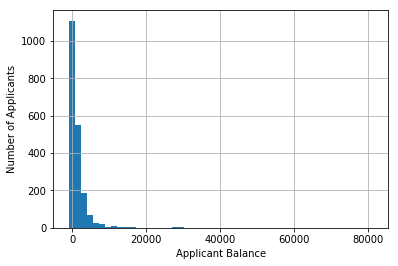

In [13]:
# Numerical plot 1 - Balance
# Look at balances 
df['balance'].hist(bins=50)
plt.xlabel('Applicant Balance')
plt.ylabel('Number of Applicants')

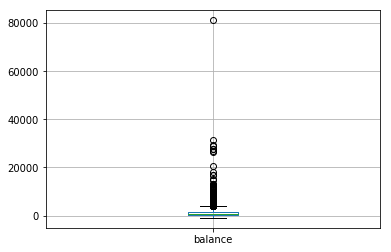

In [14]:
# Use boxplot to get better insight into this balance 
# Next, we look at boxplots to understand the distribution better.
df.boxplot(column='balance')

Shows outliers in the balance of the dataset. Majority are well below the 40K mark but outlier above 80k. Lets look into this further.

Have tertiary level education only marginally increased the balance overall which isn't what I would've expected. I would've thought that increased education level would lead to a proportionate increase in balance across data samples.

/Users/cathalc/.pyenv/versions/3.5.6/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


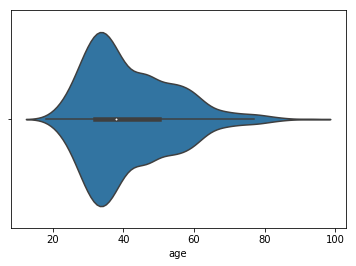

In [15]:
# Numerical Plot 2 - Age
#Plot distribution of numerical attribute 'age'
seaborn.violinplot(x=df['age'])

- Can see the majority of people are in the range 30 - 35
- Does the level of education influence the bank balance?

Text(0.5, 0.98, '')

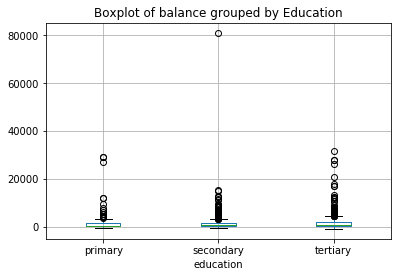

In [16]:
# Combined attributes Balance and Education
# Categorical and Numberical attributes
# Boxplots of balance, grouped by the categorical attribute Education
df.boxplot(column='balance', by='education')
plt.title('Boxplot of balance grouped by Education')
plt.suptitle("")

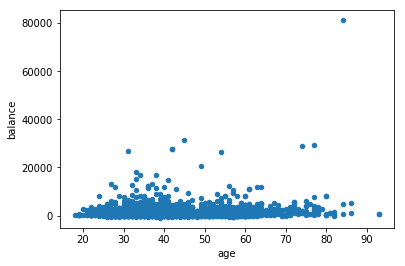

In [17]:
# Does balance increase as age increase?
# Plotting age and balance attributes.

df.plot.scatter(x='age', y='balance')

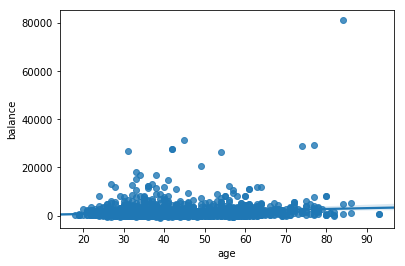

In [18]:
seaborn.regplot(x='age', y='balance', data=df)

The trend seems to be quite flat as age increases. Suggesting balances are kept hoverring around the same mean and don't fluctuate that much.

In [19]:
# Categorial Plot 1

Text(0, 0.5, 'Count')

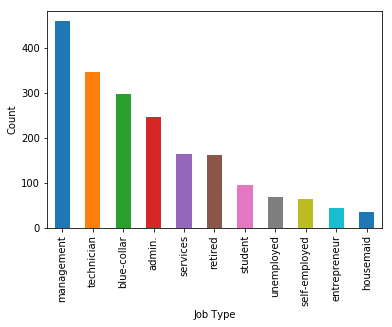

In [20]:
df['job'].value_counts().plot(kind='bar')
plt.xlabel('Job Type')
plt.ylabel('Count')

In [21]:
# Categorial Plot 2

Text(0, 0.5, 'Count')

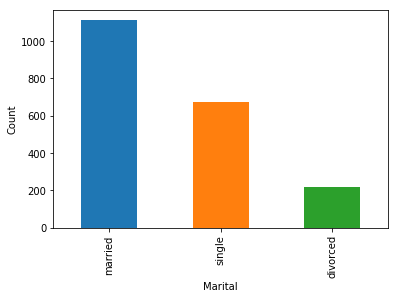

In [22]:
df['marital'].value_counts().plot(kind='bar')
plt.xlabel('Marital')
plt.ylabel('Count')

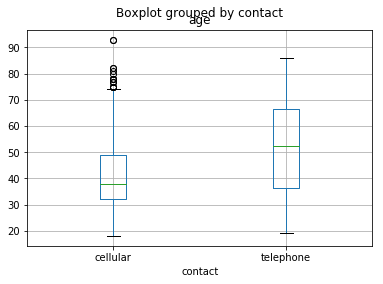

In [23]:
df.boxplot(column='age', by='contact')
# shows we have some outliers that older people tend to prefer cellular contact.

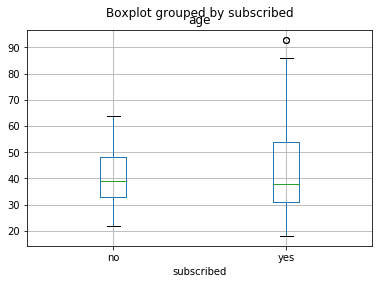

In [24]:
df.boxplot(column='age', by='subscribed')

In [25]:
df['subscribed'] = df['subscribed'].map({'yes': 1, 'no': 0})

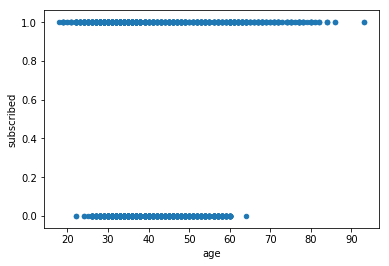

In [26]:
df.plot.scatter(x='age', y='subscribed')

### Task 3
Consider the two numerical attributes picked in Task 2 and describe (in a markdown cell) how a perceptron can be used to perform 2-class classification. Use the following terms in your description:

- Input space
- Output space
- Unknown target function
- Data set
- Hypothesis set
- Final Hypothesis
- In-sample error
- Out-of-sample error


### Task 4
Run the provided perceptron learning algorithm (PLA) on the dataset provided in the notebook. Take note of the number of iterations that were required to come to the final hypothesis and the final error. Once you are satisfied you understand these results, run the PLA algorithm on the dataset you have explored in the previous tasks (using the selected dependent variable and the two most promising numerical attributes/features). If results are unsatisfactory (if you don't get results at all, why would this be?), investigate how the PLA algorithm can be changed to improve the performance. Change the provided algorithm accordingly and plot estimates for P[Ein-Eout|>e]. Exercise 1.10 (see Python code below in the Resources section) gives an example of how you can create such plots. In the same plot add the Hoeffding Bound  and conclude whether or not the found results obey the Hoeffding Equation (in a markdown cell). Draw conclusions on whether or not you have found proof that learning is possible (in a markdown cell).

HINT: The videos discuss the 'Pocket' algorithm as an improvement on the PLA.